# 1.Import Libraries

In [1]:
import os
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import  Xception, NASNetMobile, DenseNet121
from tensorflow.keras.models import Model, load_model

In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from skimage.color import rgb2gray
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [4]:
from tf_keras_vis.gradcam import Gradcam
import shap
from tf_keras_vis import gradcam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input,  decode_predictions as decode_xception
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input, decode_predictions as decode_densenet
from tensorflow.keras.applications.nasnet import preprocess_input as  nasnet_preprocess_input, decode_predictions as decode_nasnet

# 2.Load Dataset and Apply Data Augmnetations

In [5]:
Image_Size = 224
Batch_Size = 32
Channels = 3
Epochs = 20
data_dir = "C:\\Users\\manis\\OneDrive\\Desktop\\Data Science Plan\\Major Project\\balanced_ds"

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size = Batch_Size, image_size = (Image_Size, Image_Size), shuffle = True)

class_names = dataset.class_names
class_names

Found 13368 files belonging to 6 classes.


['Bacterial Spot',
 'Early Blight',
 'Healthy',
 'Late Blight',
 'Septoria Leaf Spot',
 'Yellow Leaf Curl Virus']

In [7]:

def split_dataset(ds, train_split=0.75, val_split=0.15, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 42)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_data, val_data, test_data = split_dataset(dataset)



In [8]:

train_aug = tf.keras.Sequential([
    tf.keras.layers.Resizing(Image_Size,Image_Size),
    tf.keras.layers.Rescaling(1.0/255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.01, 0.01),
    tf.keras.layers.RandomContrast(0.3)
])


test_aug = tf.keras.Sequential([
     tf.keras.layers.Resizing(Image_Size,Image_Size),
    tf.keras.layers.Rescaling(scale=1.0/255.0)])

In [9]:

train_data = train_data.map(lambda x, y: (train_aug(x, training=True), y))

val_data = val_data.map(lambda x, y: (test_aug(x), y))

test_data = test_data.map(lambda x, y: (test_aug(x), y))

print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :418 
Batch size of Training Data is :313
Batch size of Validation Data is :62 
Batch size of Testing Data is :43 


In [10]:

train_ds = train_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

# 3. Utilize Pre-tarined Models

In [23]:

xception_model =  load_model('Xception_model.h5')
nasnet_model =  load_model('Nasnet_model.h5')
densenet_model = load_model('DenseNet121_model.h5')

In [12]:

def extract_features(model, dataset):
    total_samples = dataset.cardinality().numpy() * Batch_Size
    features = [] 
    labels = [] 
    
    for inputs, targets in dataset: 
        preds = model.predict(inputs, verbose =1)
        
       
        if preds.shape[0] != Batch_Size: 
            continue 
        features.append(preds) 
        labels.append(targets) 
       
        if len(features) * Batch_Size >= total_samples: 
            break 
    features = np.vstack(features) 
    labels = np.concatenate(labels) 
    return features, labels

In [ ]:

xception_train_features, train_labels = extract_features(xception_model, train_ds)
xception_val_features, val_labels = extract_features(xception_model, val_ds)
xception_test_features, test_label = extract_features(xception_model, test_ds)


nasnet_train_features = extract_features(nasnet_model, train_ds)[0]
nasnet_val_features = extract_features(nasnet_model, val_ds)[0]
nasnet_test_features = extract_features(nasnet_model, test_ds)[0]

densenet_train_features = extract_features(densenet_model, train_ds)[0]
densenet_val_features = extract_features(densenet_model, val_ds)[0]
densenet_test_features = extract_features(densenet_model, test_ds)[0]


In [ ]:

stacked_train_features = np.hstack([xception_train_features, nasnet_train_features, densenet_train_features])

stacked_val_features = np.hstack([xception_val_features, nasnet_val_features,densenet_val_features ])

stacked_test_features = np.hstack([xception_test_features, nasnet_test_features,densenet_test_features])

In [ ]:

np.save("stacked_train_features.npy", stacked_train_features)
np.save("stacked_val_features.npy", stacked_val_features)
np.save("stacked_test_features.npy", stacked_test_features)


np.save("train_labels.npy", train_labels)
np.save("val_labels.npy", val_labels)
np.save("test_labels.npy", test_label)

In [11]:


stacked_train_features = np.load("stacked_train_features.npy")
stacked_val_features = np.load("stacked_val_features.npy")
stacked_test_features = np.load("stacked_test_features.npy")


train_labels = np.load("train_labels.npy")
val_labels = np.load("val_labels.npy")
test_label = np.load("test_labels.npy")


# 4.Train XGBoost Classifier

In [12]:

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(stacked_train_features,train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [13]:

val_preds = xgb.predict(stacked_val_features)
accuracy = np.mean(val_preds == val_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 94.66%


In [14]:

test_preds = xgb.predict(stacked_test_features)
accuracy = np.mean(test_preds == test_label)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 94.99%


# 5.Performance Metrics

Accuracy on test set: 0.9498546511627907


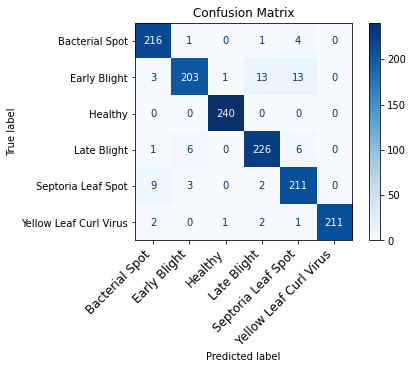

In [15]:
cm = confusion_matrix(test_label, test_preds)

accuracy = accuracy_score(test_label, test_preds)
print("Accuracy on test set:", accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  
disp.plot(cmap=plt.cm.Blues)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.title("Confusion Matrix")
plt.show()

In [16]:

print(classification_report(test_label, test_preds, target_names=class_names))

                        precision    recall  f1-score   support

        Bacterial Spot       0.94      0.97      0.95       222
          Early Blight       0.95      0.87      0.91       233
               Healthy       0.99      1.00      1.00       240
           Late Blight       0.93      0.95      0.94       239
    Septoria Leaf Spot       0.90      0.94      0.92       225
Yellow Leaf Curl Virus       1.00      0.97      0.99       217

              accuracy                           0.95      1376
             macro avg       0.95      0.95      0.95      1376
          weighted avg       0.95      0.95      0.95      1376



# 6.Random Search Optimisation

In [19]:

param_dist = {
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(200, 600),
    'gamma': uniform(0, 5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

In [ ]:

xg_boost = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

random_search = RandomizedSearchCV(
    estimator=xg_boost,
    param_distributions=param_dist,
    cv=5,               
    scoring='accuracy', 
    verbose=1,         
    n_jobs=-1           
)


random_search.fit(stacked_train_features,train_labels)


print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)


best_model = random_search.best_estimator_
y_pred = best_model.predict(stacked_test_features)
print("Test Set Accuracy:", accuracy_score(test_label, y_pred))
best_model.save_model('best_model_xgb.json')
print("Saved model as best_model_xgb")

In [17]:

best_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
best_model.load_model('best_model_xgb.json')

In [18]:

test_preds = best_model.predict(stacked_test_features)
accuracy = np.mean(test_preds == test_label)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 95.28%


Accuracy on test set: 0.9527616279069767


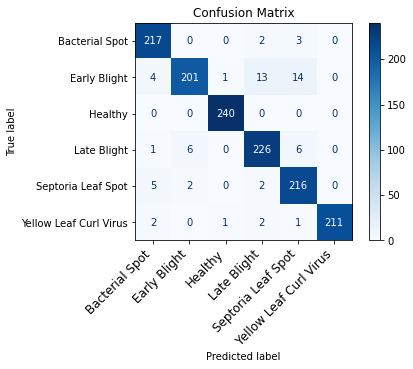

In [19]:
cm = confusion_matrix(test_label, test_preds)

accuracy = accuracy_score(test_label, test_preds)
print("Accuracy on test set:", accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  
disp.plot(cmap=plt.cm.Blues)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.title("Confusion Matrix")
plt.show()

# 7. Interpretability

## a. Implement Gradcam to understand the interpretability of CNN models

In [20]:

def preprocess_image(img_path,model_type, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    if model_type == 'xception':
        img_array = xception_preprocess_input(img_array)
    elif model_type == 'densenet':
        img_array = densenet_preprocess_input(img_array)
    elif model_type == 'nasnet':
        img_array = nasnet_preprocess_input(img_array)

    return img_array

In [21]:

class GradCAM:
    def __init__(self, model, layer_name, decode_predictions_fn):
        self.model = model
        self.layer_name = layer_name 
        self.decode_predictions_fn = decode_predictions_fn
        self.grad_model = Model(
            inputs=model.inputs,
            outputs=[model.get_layer(layer_name).output, model.output]
        )

    def predict_class(self, img_array):
        predictions = self.model.predict(img_array) 
        class_index = np.argmax(predictions[0])      
        confidence = predictions[0][class_index]     
        class_label = class_names[class_index]      
        
        return class_label, confidence
    
    def compute_heatmap(self, img_array, class_index=None):
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.grad_model(img_array)
            if class_index is None:
                class_index = np.argmax(predictions[0])
            loss = predictions[:, class_index]   

      
        grads = tape.gradient(loss, conv_outputs)
        
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

   
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

        return heatmap

    def overlay_heatmap(self, img_path, heatmap, alpha=0.5):
     
        original_img = Image.open(img_path).resize((224, 224))
        heatmap_resized = Image.fromarray(np.uint8(255 * heatmap)).resize(original_img.size)
        heatmap_resized = np.array(heatmap_resized)

        colormap = plt.cm.jet(heatmap_resized / 255.0)[:, :, :3]
        colormap = np.uint8(255 * colormap)

        overlay = Image.blend(original_img.convert("RGBA"), Image.fromarray(colormap).convert("RGBA"), alpha)
        return overlay


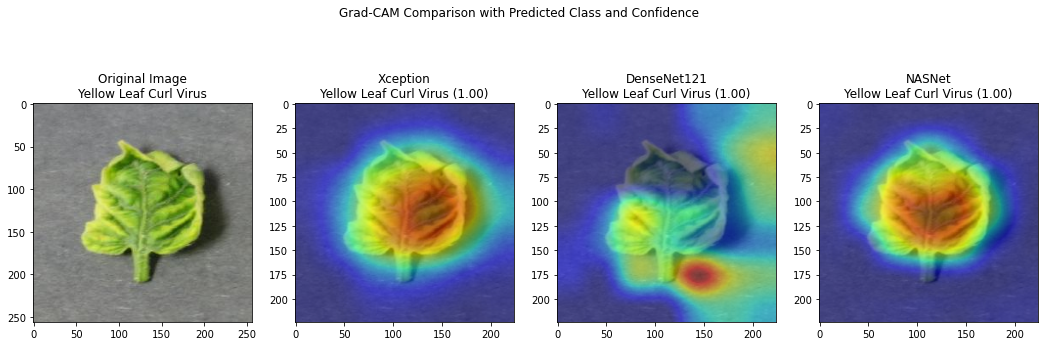

In [24]:

img_path = 'C:\\Users\\manis\\OneDrive\\Desktop\\Data Science Plan\\Major Project\\balanced_ds\\Yellow Leaf Curl Virus\\YLC2.JPG'
disease_name = img_path.split('\\')[-2]
original_img = Image.open(img_path)

gradcam_xception = GradCAM(xception_model, layer_name='block14_sepconv2_act', decode_predictions_fn=decode_xception)
gradcam_densenet = GradCAM(densenet_model, layer_name='conv5_block16_2_conv', decode_predictions_fn=decode_densenet)
gradcam_nasnet = GradCAM(nasnet_model, layer_name='activation_187', decode_predictions_fn=decode_nasnet)


xception_img = preprocess_image(img_path, model_type='xception')
densenet_img = preprocess_image(img_path, model_type='densenet')
nasnet_img = preprocess_image(img_path, model_type='nasnet')


xception_class, xception_conf = gradcam_xception.predict_class(xception_img)
densenet_class, densenet_conf = gradcam_densenet.predict_class(densenet_img)
nasnet_class, nasnet_conf = gradcam_nasnet.predict_class(nasnet_img)


heatmap_xception = gradcam_xception.compute_heatmap(xception_img)
heatmap_densenet = gradcam_densenet.compute_heatmap(densenet_img)
heatmap_nasnet = gradcam_nasnet.compute_heatmap(nasnet_img)

overlay_xception = gradcam_xception.overlay_heatmap(img_path, heatmap_xception)
overlay_densenet = gradcam_densenet.overlay_heatmap(img_path, heatmap_densenet)
overlay_nasnet = gradcam_nasnet.overlay_heatmap(img_path, heatmap_nasnet)


fig, axs = plt.subplots(1, 4, figsize=(18, 6))

axs[0].imshow(original_img)
axs[0].set_title(f'Original Image\n{disease_name}')

axs[1].imshow(overlay_xception)
axs[1].set_title(f'Xception\n{str(xception_class).title()} ({xception_conf:.2f})')

axs[2].imshow(overlay_densenet)
axs[2].set_title(f'DenseNet121\n{str(densenet_class).title()} ({densenet_conf:.2f})')

axs[3].imshow(overlay_nasnet)
axs[3].set_title(f'NASNet\n{str(nasnet_class).title()} ({nasnet_conf:.2f})')


plt.suptitle('Grad-CAM Comparison with Predicted Class and Confidence')
plt.show()


## b.Implement SHAP to understand the interpretability of the ensemble model

In [25]:


xcep_img_array = preprocess_image(img_path,'xception')
dense_img_array = preprocess_image(img_path,'densenet')
nas_img_array = preprocess_image(img_path,'nasnet')


xception_pred = xception_model.predict(xcep_img_array)
densenet_pred = densenet_model.predict(dense_img_array)
nasnet_pred = nasnet_model.predict(nas_img_array)

stacked_input = np.hstack([xception_pred, densenet_pred, nasnet_pred])


In [30]:
xception_pred

array([[3.9008967e-08, 2.3618868e-05, 6.7797060e-05, 8.1490225e-06,
        8.4763496e-06, 9.9989188e-01]], dtype=float32)

In [31]:
densenet_pred

array([[2.4159187e-08, 1.4523272e-07, 5.7508942e-07, 1.5798236e-04,
        3.2151267e-05, 9.9980909e-01]], dtype=float32)

In [26]:
stacked_input

array([[3.9008967e-08, 2.3618868e-05, 6.7797060e-05, 8.1490225e-06,
        8.4763496e-06, 9.9989188e-01, 2.4159187e-08, 1.4523272e-07,
        5.7508942e-07, 1.5798236e-04, 3.2151267e-05, 9.9980909e-01,
        1.1527067e-04, 1.7349164e-03, 5.6109980e-06, 8.9215906e-04,
        2.6963862e-05, 9.9722505e-01]], dtype=float32)

In [27]:

xgb_pred = best_model.predict(stacked_input)
class_names[xgb_pred[0]]

'Yellow Leaf Curl Virus'

In [28]:

explainer = shap.Explainer(xgb, stacked_train_features)
shap_values = explainer(stacked_input)  

## Structure of SHAP
3D Array with dimensions (num_samples, num_features, num_classes).
num_samples: Number of data points being explained.
num_features: Number of features in the input data.
num_classes: Number of output classes in the classification model.

In [29]:
shap_values

.values =
array([[[-1.75147993e+00,  1.28484326e-01,  1.95682640e-03,
          2.54637722e-02,  7.16226675e-03, -3.10231673e-02],
        [ 1.94623267e-01, -7.86339980e-01,  9.68836464e-02,
          5.08251924e-02,  4.84362189e-02, -6.42179373e-02],
        [-2.94865421e-02,  8.27894053e-02, -1.24072213e+00,
         -1.26978641e-01, -1.92147226e-01,  1.00773004e-02],
        [-1.65128748e-01, -2.14571356e-02,  1.98364031e-02,
         -9.62770489e-01,  7.10946940e-02, -4.13885286e-02],
        [-8.26200938e-03, -6.57774265e-03,  6.32267332e-03,
          8.99796052e-02, -7.79302521e-01,  1.09753967e-01],
        [ 1.63008577e-01,  4.60316627e-02, -4.47137410e-03,
         -2.83387017e-02,  2.85855987e-01,  2.74526018e+00],
        [-6.06104183e-01, -1.87901953e-01,  6.76203033e-02,
          4.80894563e-02, -4.84641829e-03,  2.62005509e-01],
        [-2.96494396e-02, -4.86105347e-01,  1.11059122e-01,
          1.72452329e-02, -6.44156056e-02,  2.67635257e-01],
        [-2.69452437e-

### The value [-1.75147993e+00] in the first row indicates that the first feature has a strong negative impact (approx. -1.75 units) on the prediction for the first class.
### The .values array explains how each feature influenced the prediction for each class, helping us understand which features matter most. 
### the shape values are for the 18 features as described below in feature_names. there are 6 values per array indicating classes

### Baseline prediction for each class (log-odds or probabilities) before considering any input features.
### It’s essentially the "starting point" of the prediction if no input features were used.
### The .base_values help us understand the model's default prediction tendency. For example:If class 0 has a much lower base value compared to other classes, it means the model is less likely to predict that class without strong feature contributions.
### #From these base values, we can infer that:

The model has a higher baseline probability for class 0 compared to others.
Class 5 is the least likely to be predicted without significant feature contributions.

### What it represents: Input data values for the corresponding samples.These are the actual feature values that were used for prediction.

Waterfall plot for Class Bacterial Spot


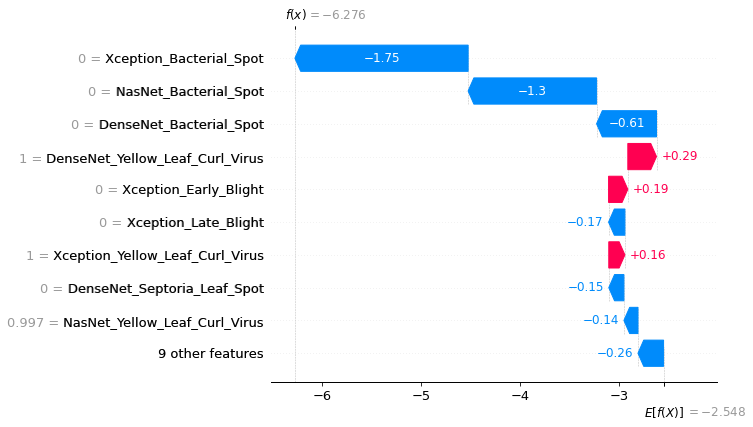

Waterfall plot for Class Early Blight


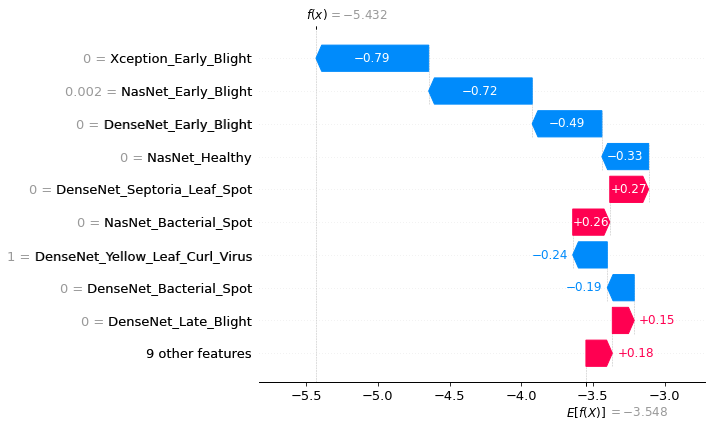

Waterfall plot for Class Healthy


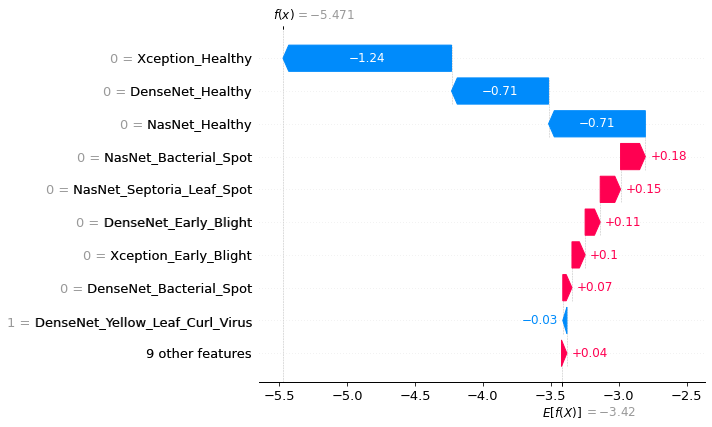

Waterfall plot for Class Late Blight


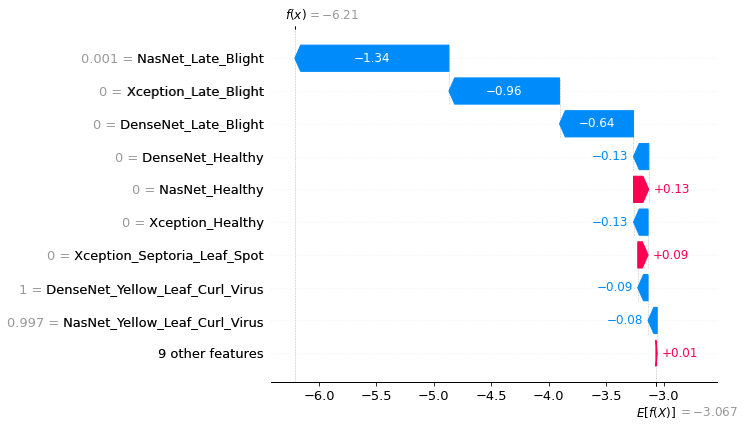

Waterfall plot for Class Septoria Leaf Spot


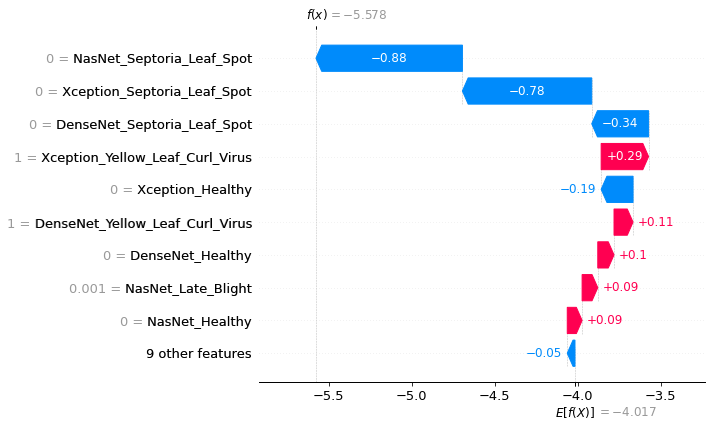

Waterfall plot for Class Yellow Leaf Curl Virus


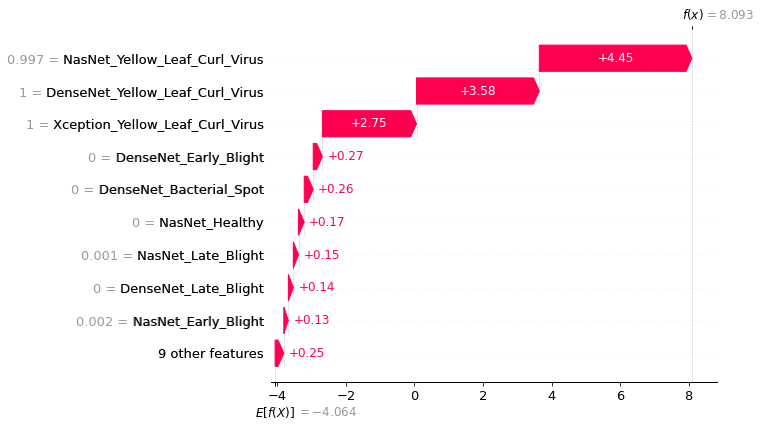

In [29]:
feature_names = [
    "Xception_Bacterial_Spot", "Xception_Early_Blight", "Xception_Healthy", "Xception_Late_Blight", "Xception_Septoria_Leaf_Spot", "Xception_Yellow_Leaf_Curl_Virus",
    "DenseNet_Bacterial_Spot", "DenseNet_Early_Blight", "DenseNet_Healthy", "DenseNet_Late_Blight", "DenseNet_Septoria_Leaf_Spot", "DenseNet_Yellow_Leaf_Curl_Virus",
    "NasNet_Bacterial_Spot", "NasNet_Early_Blight", "NasNet_Healthy", "NasNet_Late_Blight", "NasNet_Septoria_Leaf_Spot", "NasNet_Yellow_Leaf_Curl_Virus"
]



base_values = shap_values.base_values[0]  
values = shap_values.values[0]            
data = shap_values.data[0]                

for class_index in range(6):
    print(f"Waterfall plot for Class {class_names[class_index]}")
  
    shap_explanation_class = shap.Explanation(
        values=values[:, class_index],   
        base_values=base_values[class_index],  
        data=data,                        
        feature_names=feature_names
    )
    
    shap.waterfall_plot(shap_explanation_class)


100%|===================| 59870/59904 [23:33<00:00]        

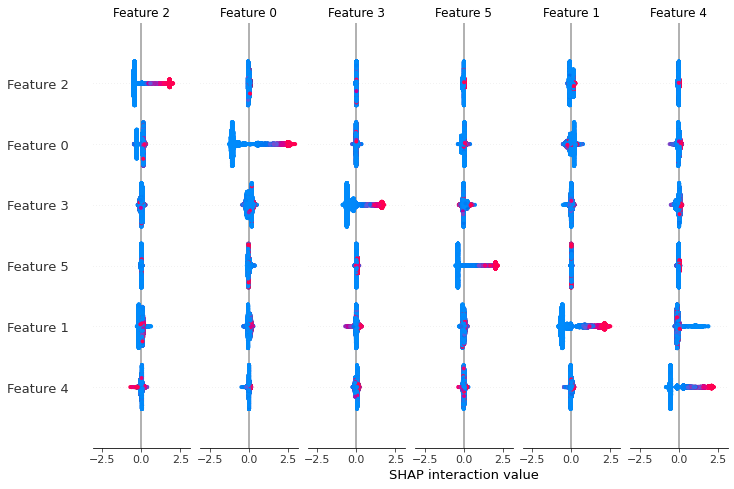

In [30]:



explainer = shap.Explainer(best_model, stacked_train_features)

shap_values = explainer(stacked_train_features)


shap.summary_plot(shap_values, stacked_train_features)
